## Predictive Modeling (GMS) -Day Subtractions From Best Model

### Summary of Previous Stage (see Notebook 3; Preprocessing_Training_CompletionRangeFiltered)

Note that for this version, puzzles from the first solve period (2018) have been removed due to the volatility of times in that solve period, while the GMS presumably "learned the ropes" of digital solving. In this version, one puzzle day at a time was subtracted out from the all 15x15 puzzles at a time. 

#### 2 Linear Regression "Benchmark" models were generated to predict GMS solve times on 15x15 (Mon-Sat) puzzles:
* 1) A "dummy" model, which simply uses mean of training data split to predict target feature -GMS's raw solve time (in min)
    * Root Mean Squared Error (RMSE) Training Set: 8.28;  Test Set: 8.09 
* 3) A univariate linear model using GMS's puzzle-day specific mean solve time across the entire sample as the sole predictive feature (ie, if predicting a Mon GMS solve time, GMS Mon mean across the entire sample is used to predict)
    * Root Mean Squared Error (RMSE) Training Set: 4.48(.37);  Test Set: 4.14
 
75%/25% Train/Test split was used for each of these Benchmark models

### High-Level Overview of Modeling

Four regression models are evaluated presently, across the entire sample of 15x15 puzzles solved by the GMS. First is simply a Linear Regression Model. The subsequent three models are decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# Ths is the file and analysis data range used for the main clay court analysis
#Note that 2018 was already filtered out prior to the data import here, though it was kept in to accrue retrospective stats on solver and constructor performance for puzzles 2019 and later
df = pd.read_csv('../data/df_for_modeling.csv')
#df.head()

,P_Date,P_Date_str,DOW,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l10_stdev,GMS_pds_l25_stdev,GMST_Diff%_from_GMS_pds_l10_dw,GMS_per_constr_avg_past_diff_from_RPB,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-03,2024-02-03,Saturday,22.583333,19.944848,21.907538,5.103116,4.545437,12.41,NaN,...,0,0,0,0,0,0,0,0,7.0,26.541479
1,2024-02-02,2024-02-02,Friday,18.783333,17.210909,17.334205,3.480521,2.455251,8.74,NaN,...,0,0,0,0,0,0,0,0,6.0,21.449373
2,2024-02-01,2024-02-01,Thursday,19.700000,15.780606,16.550718,2.244750,4.131868,22.09,7.74,...,0,0,0,0,0,0,0,0,5.0,20.709774
3,2024-01-31,2024-01-31,Wednesday,10.783333,11.621515,12.138103,2.338474,2.691352,-7.48,NaN,...,17,0,0,0,0,0,0,0,5.0,13.259712
4,2024-01-30,2024-01-30,Tuesday,7.383333,7.765758,7.783641,1.156256,1.306190,-5.05,-8.32,...,0,0,0,0,0,0,0,0,2.0,9.720614


In [1464]:
# Drop some columns that we don't want/need for modeling
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str','DOW', 'GMST_Diff%_from_GMS_pds_l10_dw','GMS_per_constr_past_diff_from_RPB_ct','Constructors','overall_day_mean_GMST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [1465]:
#Move target feature to the front
col = df_filter.pop('GMST(m)')
df_filter.insert(0, col.name, col)

In [1466]:
#Found a bad value in first modeling iteration, so correcting here
# df["Duplicate_Answers"].unique()
# df["Uniclue"].unique()
# df["Unchecked_Sq"].unique()
# df["Quantum"].unique()

In [1467]:
# Filter out a specific puzzle day
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 2)]) # minus Mon
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 3)]) #minus Tue
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 4)]) #minus Wed
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 5)]) #minus Thu
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 6)]) #minus Fri
#df_filter = (df_filter.loc[(df_filter['DOW_num'] != 7)]) #minus Sat

In [1468]:
#For full model resampled down to the same N as each subtraction model
#We will do this 10 different times and take means
#1330 is the number of rows left when subtracting out one puzzle day
df_filter = df_filter.sample(n=1330)

In [1469]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

#df_model1 = df_model1[['IS1_ST(m)', 'Comp_Hr', 'Solve_day_phase', 'IS_per_sdp_avg_past_diff_from_RPB', 'DOW_num', 'IS_pds_l10_dw', 'IS_pds_l10_stdev', 'IS_per_constr_avg_past_diff_from_RPB', 'IS1_pds_prior_solves_ct', 'IS1_npds_prior_solves_ct', 'num_solves_l7', 'Words', 'Blocks', 'Unused_Letters', 'Stacks','Unique_Answers','Rebus_Count','Rebus_Unique','Cheater_Squares','AWL','Scrabble_Score','Scrabble_Avg','FITB','Cross_Ref_Clues','Scrabble_Illegal','Open_Squares','Freshness_Factor','Overall_Freshness%','Day_Freshness%','Duplicate_Clues','Circle_Count','Shade_Count','Unusual_Sym','Black_Square_Fill','Outside_Grid','Wordplay']]

#df_model1.drop(['IS_per_constr_avg_past_diff_from_RPB','Scrabble_Score', 'IS_pds_l10_dw', 'IS_pds_l10_stdev'],inplace=True,axis=1)

In [1470]:
df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [1471]:
len(df_model1) * .75, len(df_model1) * .25

(997.5, 332.5)

In [1472]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.25, 
                                                    random_state=47)

In [1473]:
y_train.shape, y_test.shape

((997,), (333,))

In [1474]:
y_train

1488     8.933333
712      8.433333
652     11.616667
1551    18.033333
1314     9.400000
          ...    
721     18.250000
770     24.116667
1521    22.433333
1046    29.050000
869      8.066667
Name: GMST(m), Length: 997, dtype: float64

In [1475]:
X_train.shape, X_test.shape

((997, 33), (333, 33))

In [1476]:
# Get training set mean to normalize the error to, as this will change with different puzzle day subtractions
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

16.555449682380473

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [1477]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [1478]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [1479]:
#Define Grid Parameters

n_est = [100] 
learning_rate = [.04] 
max_depth = [5] 
max_features = [3]
 
grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

{'gradientboostingregressor__n_estimators': [100],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.04],
 'gradientboostingregressor__max_depth': [5],
 'gradientboostingregressor__max_features': [3]}

In [1480]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [1481]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.04],
                         'gradientboostingregressor__max_depth': [5],
                         'gradientboostingregressor__max_features': [3],
                         'gradientboostingregressor__n_estimators': [100],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [1482]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.04,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__max_features': 3,
 'gradientboostingregressor__n_estimators': 100,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [1483]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.79035701, 0.76170657, 0.70164359, 0.74134012, 0.7617797 ])

In [1484]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.7513653989743387, 0.029354754495376566)

#### Mean Absolute Error (MAE)

In [1485]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [1486]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(2.805318647883287, 0.22190771898518488)

In [1487]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

2.875782024828697

#### Mean Squared Error (MSE)

In [1488]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [1489]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(15.843780650415255, 3.165173043372933)

In [1490]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

17.690402676011168

#### Root Mean Square Error (RMSE)

In [1491]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [1492]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(3.961031329147479, 0.3924429384348869)

In [1493]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

4.205996038515867

### Best Gradient Boosting Model Feature Performance

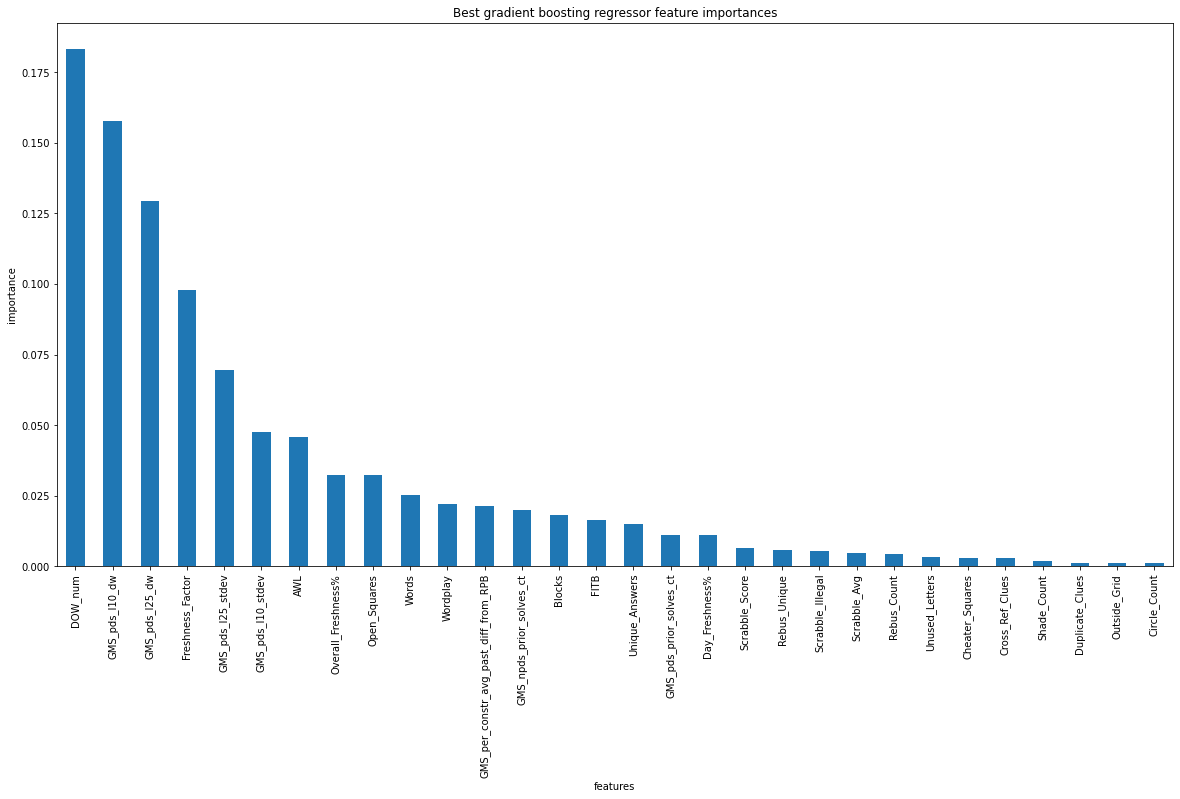

In [1494]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

In [1495]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/processed_data/gb_feat_imps.csv', index=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_data/gb_feat_imps.csv'

### Data Quality Assessment

Because Gradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. Unfortunately, it does seem like model accuracy is still rising with increased data. 

In [67]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

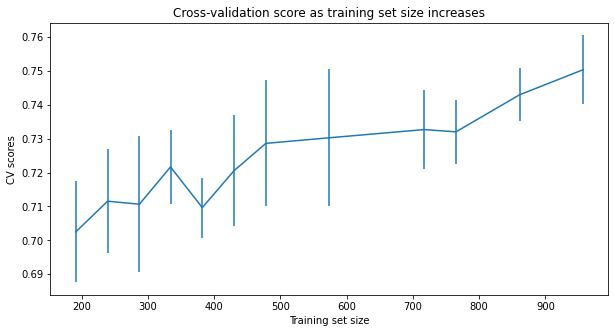

In [68]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Best GBM Model RMSE Train/Test and Best Hyperparameters (re-calibrated per substraction model)
Minus Monday:
(4.161549688695963, 0.30904287979625544), 4.668333200604575

Minus Tuesday:


## HistGradientBoosting Model

### Pipeline Creation

In [86]:
#Define pipeline
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [87]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

### Hyperparameter  Grid Search and Model Fit Using Best Parameters from Grid Search

In [88]:
#Define grid search parameters

learning_rate = [.045]
max_iterations = [110]
max_depth = [2]

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth
}
grid_params

{'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'histgradientboostingregressor__learning_rate': [0.035, 0.04, 0.045],
 'histgradientboostingregressor__max_iter': [100, 105, 110],
 'histgradientboostingregressor__max_depth': [2, 3]}

In [89]:
#First Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median'], median
#  'histgradientboostingregressor__learning_rate': [0.03, 0.04, 0.05], .04
#  'histgradientboostingregressor__max_iter': [110, 120, 130], 110
#  'histgradientboostingregressor__max_depth': [3, 4, 5]} 3

#Second Part
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'histgradientboostingregressor__learning_rate': [0.035, 0.04, 0.045], .045
#  'histgradientboostingregressor__max_iter': [100, 105, 110], 110
#  'histgradientboostingregressor__max_depth': [2, 3]} 2

In [90]:
#Call `GridSearchCV` with the hist gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation.
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [91]:
#`GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.035,
                                                                          0.04,
                                                                          0.045],
                         'histgradientboostingregressor__max_depth': [2, 3],
                         'histgradientboostingregressor__max_iter': [100, 105,
                                                                     110],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [92]:
#Best params (`best_params_` attribute) from the grid search    
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.045,
 'histgradientboostingregressor__max_depth': 2,
 'histgradientboostingregressor__max_iter': 110,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Model Cross-Validation and Fit Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [93]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.75555299, 0.75780847, 0.73008661, 0.76508302, 0.77401467])

In [94]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.7565091526484151, 0.014701752025190121)

#### Mean Absolute Error (MAE)

In [95]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [96]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(2.799733236750141, 0.14794750130022957)

In [97]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

2.6735577053174726

#### Mean Squared Error (MSE)

In [98]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv= 5)

In [99]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(16.72083460015802, 3.0625900062159643)

In [100]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

13.77431782825843

#### Root Mean Squred Error (RMSE)

In [101]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [102]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(4.073533490784517, 0.3565943067618014)

In [103]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

3.7113768103304237

Hist Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(4.073533490784517, 0.3565943067618014), 3.7113768103304237

{'histgradientboostingregressor__learning_rate': 0.035,
 'histgradientboostingregressor__max_depth': 4,
 'histgradientboostingregressor__max_iter': 125,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

## Save Best Model Object From Pipeline (Linear Model)

The Linear Model turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full dataset in a final step ().  

In [659]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [660]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_model.pkl', modelpath)

Writing file.  "../models\IS1_model.pkl"


## Conclusions
